<a href="https://colab.research.google.com/github/WiGo80/Modelos-Avanzados-2/blob/master/Solucion_MicroProyecto2_MusicRecommender_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II
# Micro-Proyecto 2

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

A continuación escriba los nombres de los integrantes del grupo.

**Nombres: Alexander Hernández Páez (200920588), Alexander Camargo (200911325), Juan David Cortés (201728568), Wilson Felipe González (200924943).**

### Introducción
Una aplicación de música quiere actualizar su aplicación online para que genere recomendaciones a sus usuarios de nuevos artistas para escuchar. El sistema de recomendación debe tomar en cuenta las preferencias de cada usuario, con el fin de ofrecer recomendaciones automáticas y personalizadas.

La base de datos que va a trabajar se ha tomado de http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html


### Enunciado 1
Por ello se le pide a usted, en calidad de consultor externo, desarrollar un algoritmo de recomendación de artistas para cada usuario. Implemente el algoritmo a partir del conjunto de datos: "lastfm-dataset-360K/usersha1-profile.tsv" y evalúe su desempeño con respecto a la métrica apropiada.

### Enunciado 2
Una vez a desarrollado su primer sistema de recomendación, intente mejorarlo con respecto a la métrica de su elección, considerando además la información que encuentra en "lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv", donde encuentra información de tipo socio-demográfico por usuario.

Veamos los datos con los que vamos a trabajar:

# 1. Filtrado colaborativo para toda la población:

In [ ]:
import pandas
import tarfile

Importamos y descomprimimos los datos:

In [ ]:
tf = tarfile.open("lastfm-dataset-360K.tar.gz")
tf.extractall()

Veamos los archivos que hemos importado:

In [ ]:
tf.getmembers()

[<TarInfo 'lastfm-dataset-360K' at 0x7f9d118b7cc8>,
 <TarInfo 'lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv' at 0x7f9d118b79a8>,
 <TarInfo 'lastfm-dataset-360K/README.txt' at 0x7f9d118b7c00>,
 <TarInfo 'lastfm-dataset-360K/mbox_sha1sum.py' at 0x7f9d118b7b38>,
 <TarInfo 'lastfm-dataset-360K/usersha1-profile.tsv' at 0x7f9d118b7f20>]

Veamos el archivo con la informacion de los usuarios y sus artistas preferidos. Esta base de datos nos dice cuantas veces un usuario a escuchado a un artista.

In [ ]:
# leemos el archivo con columnas user/artist/plays
data = pandas.read_table("lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv", 
                         usecols=[0, 2, 3], 
                         names=['user', 'artist', 'plays'])

# map each artist and user to a unique numeric value
data['user'] = data['user'].astype("category")
data['artist'] = data['artist'].astype("category")

In [ ]:
data.head(5)

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


**1.1) Preparando los datos para el ALS**

**Filtro de IDs nulos:**

In [ ]:
print(data.shape)
data.dropna(inplace=True)
data.shape

(17535655, 3)


(17535451, 3)

In [ ]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve

import random
import datetime

In [ ]:
data = data.loc[pd.isnull(data.user) == False] ### dejando solo id-s no nulos
data = data.loc[pd.isnull(data.artist) == False]
data.head(2)

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099


In [ ]:
data.shape

(17535451, 3)

In [ ]:
# verificacion
data.loc[pd.isnull(data.user) == True] ### dejando solo id-s no nulos
data.loc[pd.isnull(data.artist) == True]

,user,artist,plays


**Join información demográfica - matrizsparse**

In [ ]:
# leemos el archivo con columnas user/gender/age/country
dataP = pandas.read_table("lastfm-dataset-360K/usersha1-profile.tsv", 
                         usecols=[0, 1, 2, 3], 
                         names=['user', 'gender', 'age', 'country'])
dataP.head()

,user,gender,age,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States


In [ ]:
dataP.shape

(359347, 4)

In [ ]:
data1 = data.join(dataP.set_index('user'), on='user', how='inner')
data1.head(3)

,user,artist,plays,gender,age,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137,f,22.0,Germany
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,f,22.0,Germany
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,f,22.0,Germany


In [ ]:
print(data1.shape)
data1.dropna(inplace=True)
print(data1.shape)

(17535365, 6)
(13068352, 6)


**Eliminando los artistas que hayan sido escuchados por pocos usuarios**

In [ ]:
data1.groupby(['artist']).count().head(2)
len(np.unique(data1.artist))

249840

In [ ]:
user_artist = data1.groupby(['artist']).count().iloc[:,0] ## ordenando id´s de artistas desde los menos esuchados a los que mas
user_artist = pd.DataFrame(user_artist.sort_values(ascending=True))
user_artist.shape

(292363, 1)

In [ ]:
import plotly.express as px
df = user_artist
fig = px.histogram(df, x="user")
fig.show()

In [ ]:
#pp=round(user_artist.shape[0]*0.25)
#pp

In [ ]:
user_artist=user_artist.loc[user_artist['user']<11] ## eliminando artistas escuchados por cero usuarios
print(user_artist.shape)
indice=list(user_artist.index)
indice[0:4]
#print(len(set(indice))) ## numero de artistas a filtrar
#sum(~data1['artist'].isin(indice)) ## numero de registros en data1 despues de filtros

(238669, 1)


['�������',
 'my phuong nyugen & thierry david',
 'my own worst enemy',
 'brian eno (with moebius & roedelius)']

In [ ]:
data1=data1[~data1['artist'].isin(indice)]
print(data1.shape)
len(np.unique(data1.artist))

(12603324, 6)


53694

**Filtrando usuarios que escuchan pocos artistas**

In [ ]:
#print(data1.groupby(['user']).count().head(5))
#data1.groupby(['user']).count().iloc[:,0]

In [ ]:
#user_artist = data1.groupby(['user']).count().iloc[:,0] ## ordenando id´s de usuarios desde los que escuchan pocos artistas a los que mas.
#user_artist = pd.DataFrame(user_artist.sort_values(ascending=True))
#print(user_artist.head(2))
#data1.shape

In [ ]:
#pp=round(data1.user.unique().shape[0]*.2) ## indice para el yy % de los usuarios que escuchan menos artistas
#indice=list(user_artist.index[0:pp])
#print(len(set(indice))) ## numero de ususarios a filtrar
#sum(~data1['user'].isin(indice)) ## numero de registros en data1 despues de filtros

In [ ]:
#data1=data1[~data1['user'].isin(indice)]
data1.shape

(12603324, 6)

**Eliminando los usuarios que tienen como id (sep 20, 2008), lo anterior porque pueden estar mezclandose usuarios**

In [ ]:
data1['conteo'] = data1['user'].str.len()
data1['conteo']

0           40
1           40
2           40
3           40
4           40
            ..
17535602    40
17535603    40
17535604    40
17535605    40
17535606    40
Name: conteo, Length: 12603324, dtype: int64

In [ ]:
#Se eliminan los usuarios que tengan menos de 40 caracteres en su ID:
data1['conteo'] = data1['user'].str.len()
data1.groupby(['conteo']).count()
data1 = data1[~data1['conteo'].isin([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39])]
data1 = data1.drop(['conteo'], axis=1)
data1.shape

(12603324, 6)

**Evaluando el genero**

In [ ]:
np.unique(data1.gender) ## evaluando genero

array(['f', 'm'], dtype=object)

**Evaluando la edad**

In [ ]:
data1=data1[data1.age<81]
data1=data1[data1.age>12]

**Evaluando el peso por pais**

In [ ]:
mean_age_pais = data1.groupby(['country']).mean() ## evaluando edad
mean_age_pais2 = mean_age_pais.sort_values(by='age', ascending=True)
mean_age_pais2

,plays,age
country,,
Benin,612.040816,17.000000
Comoros,231.802632,17.907895
Liberia,206.166667,18.000000
Mayotte,115.868852,18.409836
Eritrea,603.494118,18.923529
...,...,...
Northern Mariana Islands,173.150442,31.952802
Anguilla,116.121795,32.333333
Belize,77.489796,32.392857


In [ ]:
regs_pais = data1.groupby(['country']).count() ## evaluando paises
regs_pais=pd.DataFrame(regs_pais.sort_values(by='user', ascending=True).iloc[:,0])
print(regs_pais)
regs_pais=regs_pais[regs_pais.user<100]
indice=list(regs_pais.index)
data1=data1[~data1['country'].isin(indice)]

                             user
country                          
Liberia                        42
Central African Republic       42
Benin                          49
Sudan                          85
Palau                         100
...                           ...
Russian Federation         662422
Poland                     773463
United Kingdom            1012996
Germany                   1086203
United States             2332653

[238 rows x 1 columns]


**Exportando datos depurados**

In [ ]:
#data1.to_csv('data.csv', sep='\t')

**1.2) Definimos matriz tipo Sparse y "particionamos" en entrenamiento y validación:**

In [ ]:
from pandas.api.types import CategoricalDtype

usuarios = list(np.sort(data1.user.unique())) 
items = list(data1.artist.unique()) 
confianza = list(data1.plays)

cat_type1 = CategoricalDtype(categories=usuarios)
cat_type2 = CategoricalDtype(categories=items)


# Construimos la matriz
filas = data1.user.astype(cat_type1).cat.codes 
cols = data1.artist.astype(cat_type2).cat.codes 
prefs_sparse = sparse.csr_matrix((confianza, (filas, cols)), shape=(len(usuarios), len(items)))

In [ ]:
prefs_sparse

<264779x53694 sparse matrix of type '<class 'numpy.longlong'>'
	with 12498313 stored elements in Compressed Sparse Row format>

**La matriz tiene 264,779 usuarios y 53,694 artistas. De todas las posibles interacciones, se tienen 12,498,313 no nulas.**

In [ ]:
# Interacciones posibles
mat_dim = prefs_sparse.shape[0]*prefs_sparse.shape[1] 

# Numero de interacciones
num_ventas = len(prefs_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_ventas/mat_dim))
sparsity

99.91208922664383

**Función que enmascara datos en validacion**

In [ ]:
def entrena(ratings, pct_val = 0.3):
    '''
    Input: Matriz de ratings
    Output: matriz de entrenamiento CE y de validacion CV, y user_inds
    
    Esta función toma la matriz orginal y enmascara un porcentaje de ratings pata la validacion
    El conjunto de validacion (CV) va a tener todos los ratings originales, mientras que el de entrenamiento (CE)
    reemplaza el porcentaje señalado con ceros
    
    pct_val: porcentaje de iteraciones a enmascarar
    user_inds: lista de usuarios aleatoriamente elegidos y enmascarados en CE.
    '''
    
    random.seed(0) # Semilla aeatoria
    
    CV = ratings.copy() 
    CV[CV != 0] = 1 # CV como una matriz binaria
    
    CE = ratings.copy() 
    non0_inds = CE.nonzero() # Indices donde hay interaccion
    non0_pares = list(zip(non0_inds[0], non0_inds[1])) # lista de indices usuario-item con interaccion
    
    num_muestra = int(np.ceil(pct_val*len(non0_pares)))
    muestra = random.sample(non0_pares, num_muestra) # sub-muestreo sin reemplazo de pares (usuario-item) con interaccion.
    
    user_inds = [index[0] for index in muestra] # indices de usuario
    item_inds = [index[1] for index in muestra] # inidices de items
    
    CE[user_inds, item_inds] = 0 # Asigna 0 sobre las observaciones elegidas
    CE.eliminate_zeros() # Elimina los ceros en el arreglo sparce
    return CE, CV, list(set(user_inds)) 

In [ ]:
CE, CV, users_V = entrena(prefs_sparse, pct_val = 0.2)

**1.3) Mínimos cuadrados alternantes**

In [ ]:
import scipy  ## debe ser 0.16 o posterior
scipy.__version__

'1.4.1'

In [ ]:
pip install implicit

In [ ]:
import implicit

In [ ]:
alpha = 11
user_vecs, item_vecs = implicit.alternating_least_squares((CE*alpha).astype('double'), 
                                                          factors=32, 
                                                          regularization = 0.15, 
                                                          iterations = 50)

**1.4) Evaluación de nuestro sistema de recomendación**

In [ ]:
from sklearn import metrics

In [ ]:
def auc_score(preds, prueba):
    '''
    Esta funcion obtiene el AUC. 
    Input:
    parameters:
    preds: las predicciones del sistema
    prueba: las ventas verdaderas
    Output:
    AUC
    '''
    
    fpr, tpr, umbrales = metrics.roc_curve(prueba, preds)
    return metrics.auc(fpr, tpr)  

In [ ]:
def AUC_val(CE, users_V, preds, CV):
    '''
    Esta funcion calcula el AUC medio por usuario para todo usuario en el conjunto de validacion
    Input:
    CE: Conjunto de entrnamiento con un porcentaje de las interacciones originales enamscaradas
    preds: la matriz con las predicciones de los ratings para cada par usuario-item (lista
    con vectores de usuario y vectores de items)
    users_V: indices de los usuarios de validacion
    CV: conjunto de validacion 
    Output:
    AUC medio del CV para las interacciones usuario-item y para los items más populares
    '''
    
    # Inicializamos la lista para guardar el AUC de validacion 
    rec_auc = [] 
    # y el AUC para la recomendación por popularidad
    pop_auc = [] 
    
    # Tomamos la suma de interacciones por item para encontrar lo más popular
    pop_items = np.array(CV.sum(axis = 0)).reshape(-1) 
    item_vecs = preds[1]
    
    for user in users_V: 
        user_i = CE[user,:].toarray().reshape(-1) # usuario de validacion
        user_val = np.where(user_i == 0) # 
        
        # Toma la prediccion para el usuario-item
        user_vec = preds[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,user_val].reshape(-1)
        print(user)
        # Selecciona los ratings estimados para el usuario 
        actual = CV[user,:].toarray()[0,user_val].reshape(-1) 
        
        # Toma los pares con interacciones binarias de los datos originales
        pop = pop_items[user_val] # Popularidad del item
        rec_auc.append(auc_score(pred, actual)) # Calcula y guarda el AUC para el ususario
        pop_auc.append(auc_score(pop, actual)) # Calcula el AUC por popularidad

    
    return float('%.3f'%np.mean(rec_auc)), float('%.3f'%np.mean(pop_auc))  
   # Devuelve el AUC medio para validacion y por popularidad

In [ ]:
#####

In [ ]:
AUC_val(CE, users_V, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], CV)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
259777
259778
259779
259780
259781
259782
259783
259784
259785
259786
259787
259788
259789
259790
259791
259792
259793
259794
259795
259796
259797
259798
259799
259800
259801
259802
259803
259804
259805
259806
259807
259808
259809
259810
259811
259812
259813
259814
259815
259816
259817
259818
259819
259820
259821
259822
259823
259824
259825
259826
259827
259828
259829
259830
259831
259832
259833
259834
259835
259836
259837
259838
259839
259840
259841
259842
259843
259844
259845
259846
259847
259848
259849
259850
259851
259852
259853
259854
259855
259856
259857
259858
259859
259860
259861
259862
259863
259864
259865
259866
259867
259868
259869
259870
259871
259873
259874
259875
259876
259877
259878
259879
259880
259881
259882
259883
259884
259885
259886
259887
259888
259889
259890
259891
259892
259893
259894
259895
259896
259897
259898
259899
259900
259901
259902
259903
259904
259905
259906
259907
259908
259909
259910
25

(0.979, 0.911)

**1.5) Resultados**

In [ ]:
print(user_vecs.shape)
print(item_vecs.shape)
user_vecs[[0]]

(264779, 32)
(53694, 32)


array([[ 0.00260039,  0.00152129,  0.00897462,  0.00554981,  0.01467435,
         0.00784064,  0.00743239,  0.01243313, -0.00313622,  0.0071495 ,
        -0.00114579,  0.00549853,  0.00742546, -0.00290146, -0.00129345,
         0.01339867,  0.00519619,  0.00069158, -0.00029853, -0.00361427,
         0.00062617, -0.00018549,  0.01401833,  0.01208037,  0.00056619,
         0.00391487,  0.0076041 ,  0.00141338,  0.00719805,  0.00469846,
         0.01064805,  0.01688788]], dtype=float32)

In [ ]:
ratings=user_vecs[0,:].dot(item_vecs.T) ## ratings para un usuario
print(ratings.shape)
print(len(items))
ratings[0:11]

(53694,)
53694


array([0.98475295, 0.6463159 , 0.9718471 , 0.94223726, 1.0054029 ,
       1.035673  , 0.87100995, 0.9012641 , 1.0680497 , 1.0046711 ,
       1.1230636 ], dtype=float32)

In [ ]:
ind_top10=(-ratings).argsort()[:10]
print(ind_top10)
ind_top10[0]

[9976 9690 3768 1936 2956 2006 4141   13 4398 1050]


9976

In [ ]:
for i in (0,1,2,3,4,5,6,7,8,9):
  print(items[ind_top10[i]])
  print(ratings[ind_top10[i]])

voltaire
1.6428589
the donnas
1.5382259
the pillows
1.5220014
anna ternheim
1.5106533
amanda palmer
1.4877017
silverchair
1.4865986
dir en grey
1.4753463
horrorpops
1.4685667
菅野よう子
1.4641826
they might be giants
1.4483628



#2. También podemos ver informacion social/demográfica sobre los usuarios:

In [ ]:
data1.head(3)

,user,artist,plays,gender,age,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137,f,22.0,Germany
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,f,22.0,Germany
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,f,22.0,Germany


In [ ]:
len(np.unique(data1.country)) ## no de paises

234

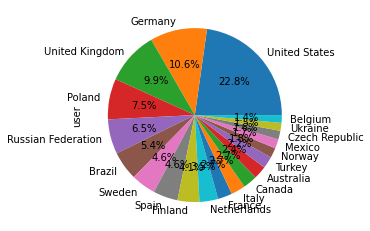

In [ ]:
# peso por pais
cont_pais = data1.groupby(['country']).count().iloc[:,0]
cont_pais2 = cont_pais.sort_values(ascending=False)
cont_pais2.iloc[0:20,].plot.pie(autopct='%1.1f%%')

# 3. Segmentación

**Agrupando por usuario y calculando dos nuevas variables: no de plays y no de artistas esuchados por usuario**

In [ ]:
var1=pd.DataFrame(data1.groupby(['user']).count().iloc[:,0])
var2=pd.DataFrame(data1.groupby(['user']).sum().iloc[:,0])
data_seg=pd.concat([var1,var2], axis=1, ignore_index=False)
data_seg.head(3)

,artist,plays
user,,
00000c289a1829a808ac09c00daf10bc3c4e223b,49,16716
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,48,572
00007a47085b9aab8af55f52ec8846ac479ac4fe,50,6115


In [ ]:
data_seg=data_seg.join(dataP.set_index('user'), on='user', how='inner') ### agregando informacion demográfica
data_seg.head()

,artist,plays,gender,age,country
user,,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,49,16716,f,22.0,Germany
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,48,572,m,19.0,Mexico
00007a47085b9aab8af55f52ec8846ac479ac4fe,50,6115,m,28.0,United States
0000c176103e538d5c9828e695fed4f7ae42dd01,49,25213,m,20.0,United Kingdom
0000ee7dd906373efa37f4e1185bfe1e3f8695ae,49,7252,m,17.0,Finland


In [ ]:
print(data_seg.shape)
print(len(data1.user.unique()))
len(np.unique(data_seg.country)) ## no de paises

(264779, 5)
264779


234

In [ ]:
#### intento de ACM

#percs_artist = np.percentile(data_seg.artist, (25,50,75)) ## categorizando el no de artistas
#percs_plays = np.percentile(data_seg.plays, (25,50,75)) ## categorizando el no de plays

#umbrales1=[min(data_seg.artist)-1,percs_artist[0],percs_artist[1],percs_artist[2],max(data_seg.artist)+1]
#umbrales2=[min(data_seg.plays)-1,percs_plays[0],percs_plays[1],percs_plays[2],max(data_seg.plays)+1]

In [ ]:
#categorias=["cuartil1","cuartil2","cuartil3","cuartil4"]

#data_seg['no_artistas']=pd.cut(x=data_seg['artist'],bins=umbrales1,labels=categorias)
#data_seg['no_plays']=pd.cut(x=data_seg['plays'],bins=umbrales2,labels=categorias)

In [ ]:
#data_seg=data_seg.iloc[:,3:7]
#data_seg.head(3)

**ANALISIS FACTORIAL**

In [ ]:
pip install prince

In [ ]:
import prince

In [ ]:
#mca = prince.MCA(n_components=100)
#facto = mca.fit(data_seg) # same as calling ca.fs_r(1)
#facto = mca.transform(data_seg) # same as calling ca.fs_r_sup(df_new) for *another* test set.

In [ ]:
#facto.head(3)

In [ ]:
#mca.total_inertia_

In [ ]:
#mca.plot_coordinates(
#X=data_seg,
#ax=None,
#figsize=(6, 6),
#show_row_points=True,
#row_points_size=10,
#show_row_labels=False,
#show_column_points=True,
#column_points_size=30,
#show_column_labels=False,
#legend_n_cols=1
#)

In [ ]:
import prince
famd = prince.FAMD(
n_components=240,
n_iter=5,
copy=True,
check_input=True,
engine='auto',
random_state=42
)
famd = famd.fit(data_seg)

In [ ]:
facto = famd.transform(data_seg)

**K MEANS**

In [ ]:
print(facto.shape)
facto.head(3)

(264779, 239)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,-0.926261,0.677372,-0.817511,-0.088037,0.948164,2.421103,-0.912030,0.010694,0.015235,-0.112771,0.081284,-0.029516,0.034972,-0.117637,0.035028,0.022269,-0.060995,-0.037996,0.027830,0.009430,-0.049289,0.037747,0.039906,0.006737,-0.029411,-0.010500,-0.004755,-0.000221,-0.026350,-0.009266,-0.016628,0.003081,-0.012732,0.014274,-0.004214,-0.016638,-0.025430,0.017801,0.004934,0.009228,...,9.228872e-15,1.321977e-13,0.000101,-0.000413,-0.000101,-0.000097,-0.000152,2.460822e-13,-7.721405e-14,1.888165e-13,-2.505536e-14,-1.903811e-14,0.000065,-0.000038,-0.000219,0.000045,-0.000221,-6.757967e-13,-9.091030e-13,-7.101777e-13,7.665659e-13,2.387519e-13,0.000242,-0.000201,-0.000033,0.000023,-0.000240,-3.618114e-13,-2.441366e-13,-1.476349e-13,-6.351977e-15,0.000170,-0.000219,-0.000022,-0.411745,0.698798,0.220068,0.030951,7.365386e-16,8.130889e-17
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,-0.068744,-0.314527,0.255942,-1.092399,-0.640101,-0.113842,0.326875,-0.053997,-0.010612,0.357101,-0.576118,0.145086,-0.094072,0.827323,-0.049125,-0.324726,0.536800,3.343376,-4.314738,1.277067,-3.310469,1.210286,0.363974,0.274029,-0.306605,-0.162467,-0.054163,0.164523,-0.256473,0.032600,0.126863,-0.001846,-0.176569,0.147106,-0.063640,-0.146245,-0.129131,0.096277,-0.028376,-0.012201,...,-1.589808e-13,1.268666e-12,-0.000469,-0.002436,-0.000707,-0.000998,-0.001048,2.185702e-12,-3.048234e-13,1.175852e-12,1.627254e-13,-8.104622e-13,0.000133,-0.001076,-0.000887,0.000147,-0.001474,-4.626553e-12,-5.647254e-12,-4.915777e-12,4.831914e-12,2.019224e-12,0.001142,-0.000787,-0.000720,0.000533,-0.001506,-2.895152e-12,-2.002749e-12,-5.079455e-14,7.885921e-13,0.000196,-0.001542,-0.000082,0.125158,0.318921,-0.247478,-0.555100,4.947458e-16,-2.152753e-15
00007a47085b9aab8af55f52ec8846ac479ac4fe,0.752313,0.018281,-0.394526,0.888371,-1.207414,0.044972,-0.300534,-0.259412,0.086408,0.019930,-0.034448,-0.066474,0.015146,-0.011108,-0.010774,-0.033726,0.007246,-0.050015,-0.030008,-0.026494,-0.010496,-0.006283,-0.028465,-0.036202,-0.014288,0.010989,-0.007772,-0.041820,0.016102,0.024629,-0.013171,0.011760,-0.000586,-0.020502,-0.016793,0.003894,-0.029125,-0.005034,0.024262,-0.000895,...,2.564820e-15,1.863870e-14,-0.000131,-0.000050,-0.000263,0.000058,-0.000064,-3.292776e-13,-2.003396e-13,1.056647e-13,-1.687827e-13,-1.831038e-14,-0.000356,-0.000020,-0.000128,0.000037,-0.000039,-8.333245e-15,-3.182936e-13,-1.552136e-13,1.622339e-13,-5.422631e-14,-0.000177,-0.000199,-0.000033,-0.000026,-0.000082,-4.589514e-14,-1.417962e-13,1.206063e-14,-8.801358e-14,-0.000010,-0.000089,-0.000042,0.121789,-0.717751,-0.387032,-0.291458,3.388610e-16,1.210459e-16


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=5,random_state=1050)

In [ ]:
kmeans.fit(facto)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1050, tol=0.0001, verbose=0)

In [ ]:
segmentos = pd.DataFrame()
segmentos['segmento']=pd.DataFrame(kmeans.labels_).iloc[:,0]
segmentos.index=data_seg.index

In [ ]:
print(segmentos.shape)
segmentos.head(3)

(264779, 1)


,segmento
user,
00000c289a1829a808ac09c00daf10bc3c4e223b,2
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,2
00007a47085b9aab8af55f52ec8846ac479ac4fe,2


In [ ]:
segmentos['segmento'].value_counts()

2    248777
0      9499
4      3516
1      2069
3       918
Name: segmento, dtype: int64

# 4. FILTRADO COLABORATIVO POR SEGMENTO

In [ ]:
data_seg=pd.concat([data_seg,segmentos], axis=1, ignore_index=False) # agregar segmento a data_seg
#data_seg1.rename(columns={'0':'artist','1':'plays','2':'gender','3':'age','4':'country','5':'segmento'},inplace=True)
data_seg.head(3)

,artist,plays,gender,age,country,segmento
user,,,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,49,16716,f,22.0,Germany,2
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,48,572,m,19.0,Mexico,2
00007a47085b9aab8af55f52ec8846ac479ac4fe,50,6115,m,28.0,United States,2


In [ ]:
print(data_seg.columns.values)
data1.columns.values

['artist' 'plays' 'gender' 'age' 'country' 'segmento']


array(['user', 'artist', 'plays', 'gender', 'age', 'country'],
      dtype=object)

In [ ]:
data_seg['user']=segmentos.index
data_seg.head(3)

,artist,plays,gender,age,country,segmento,user
user,,,,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,49,16716,f,22.0,Germany,2,00000c289a1829a808ac09c00daf10bc3c4e223b
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,48,572,m,19.0,Mexico,2,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf
00007a47085b9aab8af55f52ec8846ac479ac4fe,50,6115,m,28.0,United States,2,00007a47085b9aab8af55f52ec8846ac479ac4fe


In [ ]:
results=data1.join(data_seg.segmento, on='user', how='left') # join con data 1
results.head()

,user,artist,plays,gender,age,country,segmento
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137,f,22.0,Germany,2
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,f,22.0,Germany,2
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,f,22.0,Germany,2
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,f,22.0,Germany,2
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,f,22.0,Germany,2


In [ ]:
print(results.shape)
print(data1.shape)

(12498362, 7)
(12498362, 6)


**para el segmento 1**

In [ ]:
slicee=results[results.segmento==0]
print(slicee.head())
slicee.shape

                                         user  ... segmento
506  000163263d2a41a3966a3746855b8b75b7d7aa83  ...        0
507  000163263d2a41a3966a3746855b8b75b7d7aa83  ...        0
508  000163263d2a41a3966a3746855b8b75b7d7aa83  ...        0
509  000163263d2a41a3966a3746855b8b75b7d7aa83  ...        0
510  000163263d2a41a3966a3746855b8b75b7d7aa83  ...        0

[5 rows x 7 columns]


(471577, 7)

In [ ]:
from pandas.api.types import CategoricalDtype

usuarios = list(np.sort(slicee.user.unique())) 
items = list(slicee.artist.unique()) 
confianza = list(slicee.plays)

cat_type1 = CategoricalDtype(categories=usuarios)
cat_type2 = CategoricalDtype(categories=items)


# Construimos la matriz
filas = slicee.user.astype(cat_type1).cat.codes 
cols = slicee.artist.astype(cat_type2).cat.codes 
prefs_sparse = sparse.csr_matrix((confianza, (filas, cols)), shape=(len(usuarios), len(items)))

In [ ]:
# Interacciones posibles
mat_dim = prefs_sparse.shape[0]*prefs_sparse.shape[1] 

# Numero de interacciones
num_ventas = len(prefs_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_ventas/mat_dim))
sparsity

99.81152989639526

In [ ]:
CE, CV, users_V = entrena(prefs_sparse, pct_val = 0.2)

In [ ]:
alpha = 11
user_vecs, item_vecs = implicit.alternating_least_squares((CE*alpha).astype('double'), 
                                                          factors=32, 
                                                          regularization = 0.15, 
                                                          iterations = 50)

In [ ]:
AUC_val(CE, users_V, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], CV)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
468

(0.935, 0.916)

**Resultados**

In [ ]:
usuarios[0]

'000163263d2a41a3966a3746855b8b75b7d7aa83'

In [ ]:
ratings=user_vecs[0,:].dot(item_vecs.T) ## ratings para un usuario
print(ratings.shape)
print(len(items))
ratings[0:11]

(26341,)
26341


array([1.0018711 , 0.99924135, 0.9940821 , 0.99425673, 0.9966806 ,
       0.9902444 , 0.9981443 , 0.99996877, 0.99497634, 1.0030379 ,
       0.9923403 ], dtype=float32)

In [ ]:
ind_top10=(-ratings).argsort()[:10]
print(ind_top10)
ind_top10[0]

[1405 1915 1991 1996 1068 2292 1855  290  630  101]


1405

In [ ]:
for i in (0,1,2,3,4,5,6,7,8,9):
  print(items[ind_top10[i]])
  print(ratings[ind_top10[i]])

cansei de ser sexy
1.2700479
jet
1.1737851
emil jensen
1.1459377
the perishers
1.1406673
bad cash quartet
1.1396515
the raconteurs
1.1045403
peter bjorn and john
1.1029181
the bravery
1.0789583
the fray
1.0505247
the postal service
1.0414388


**Para el segmento 2**

In [ ]:
  slicee=results[results.segmento==1]
  slicee.head()

,user,artist,plays,gender,age,country,segmento
9167,002174b9a6bc649d25ef413c8d5be4f7f407cd9a,café tacuba,335,f,29.0,Argentina,1
9168,002174b9a6bc649d25ef413c8d5be4f7f407cd9a,pez,273,f,29.0,Argentina,1
9169,002174b9a6bc649d25ef413c8d5be4f7f407cd9a,radiohead,269,f,29.0,Argentina,1
9170,002174b9a6bc649d25ef413c8d5be4f7f407cd9a,luis alberto spinetta,175,f,29.0,Argentina,1
9171,002174b9a6bc649d25ef413c8d5be4f7f407cd9a,31knots,126,f,29.0,Argentina,1


In [ ]:
usuarios = list(np.sort(slicee.user.unique())) 
items = list(slicee.artist.unique()) 
confianza = list(slicee.plays)

cat_type1 = CategoricalDtype(categories=usuarios)
cat_type2 = CategoricalDtype(categories=items)


# Construimos la matriz
filas = slicee.user.astype(cat_type1).cat.codes 
cols = slicee.artist.astype(cat_type2).cat.codes 
prefs_sparse = sparse.csr_matrix((confianza, (filas, cols)), shape=(len(usuarios), len(items)))

In [ ]:
  mat_dim = prefs_sparse.shape[0]*prefs_sparse.shape[1] 

  # Numero de interacciones
  num_ventas = len(prefs_sparse.nonzero()[0]) 
  sparsity = 100*(1 - (num_ventas/mat_dim))
  sparsity

99.63817615372292

In [ ]:
CE, CV, users_V = entrena(prefs_sparse, pct_val = 0.2)

In [ ]:
alpha = 11
user_vecs, item_vecs = implicit.alternating_least_squares((CE*alpha).astype('double'), 
                                                            factors=32, 
                                                            regularization = 0.15, 
                                                            iterations = 50)

In [ ]:
AUC_val(CE, users_V, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], CV)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(0.877, 0.877)

**Resultados**

In [ ]:
#ratings=user_vecs[0,:].dot(item_vecs.T) ## ratings para un usuario
#print(ratings.shape)
#print(len(items))
#ratings[0:11]

In [ ]:
#ind_top10=(-ratings).argsort()[:10]
#print(ind_top10)
#ind_top10[0]

In [ ]:
#for i in (0,1,2,3,4,5,6,7,8,9):
#  print(items[ind_top10[i]])
#  print(ratings[ind_top10[i]])

**Para el segmento 3**

In [ ]:
slicee=results[results.segmento==2]
slicee.head()

,user,artist,plays,gender,age,country,segmento
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137,f,22.0,Germany,2
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,f,22.0,Germany,2
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,f,22.0,Germany,2
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,f,22.0,Germany,2
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,f,22.0,Germany,2


In [ ]:
usuarios = list(np.sort(slicee.user.unique())) 
items = list(slicee.artist.unique()) 
confianza = list(slicee.plays)

cat_type1 = CategoricalDtype(categories=usuarios)
cat_type2 = CategoricalDtype(categories=items)


# Construimos la matriz
filas = slicee.user.astype(cat_type1).cat.codes 
cols = slicee.artist.astype(cat_type2).cat.codes 
prefs_sparse = sparse.csr_matrix((confianza, (filas, cols)), shape=(len(usuarios), len(items)))

In [ ]:
mat_dim = prefs_sparse.shape[0]*prefs_sparse.shape[1] 

  # Numero de interacciones
num_ventas = len(prefs_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_ventas/mat_dim))
sparsity

99.91213586771589

In [ ]:
CE, CV, users_V = entrena(prefs_sparse, pct_val = 0.2)

In [ ]:
alpha = 11
user_vecs, item_vecs = implicit.alternating_least_squares((CE*alpha).astype('double'), 
                                                            factors=32, 
                                                            regularization = 0.15, 
                                                            iterations = 50)

In [ ]:
AUC_val(CE, users_V, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], CV)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
243773
243774
243775
243776
243777
243778
243779
243780
243781
243782
243783
243784
243785
243786
243787
243788
243789
243790
243791
243792
243793
243794
243795
243796
243797
243798
243799
243800
243801
243802
243803
243804
243805
243806
243807
243808
243809
243810
243811
243812
243813
243814
243815
243816
243817
243818
243819
243820
243821
243822
243823
243824
243825
243826
243827
243828
243829
243830
243831
243832
243833
243834
243835
243836
243837
243838
243839
243840
243841
243842
243843
243844
243845
243846
243847
243848
243849
243850
243851
243852
243853
243854
243855
243856
243857
243858
243859
243860
243861
243862
243863
243864
243865
243866
243867
243868
243869
243870
243871
243872
243873
243874
243875
243876
243877
243878
243879
243880
243881
243882
243883
243884
243885
243886
243887
243888
243889
243890
243891
243892
243893
243894
243895
243896
243897
243898
243899
243900
243901
243902
243903
243904
243905
24

(0.978, 0.911)

**Resultados**

In [ ]:
usuarios[0]

'00000c289a1829a808ac09c00daf10bc3c4e223b'

In [ ]:
ratings=user_vecs[0,:].dot(item_vecs.T) ## ratings para un usuario
print(ratings.shape)
print(len(items))
ratings[0:11]

(53637,)
53637


array([0.9779918 , 0.73508954, 0.9823941 , 0.99918187, 1.001219  ,
       1.0322871 , 0.8986191 , 0.8977519 , 1.0322627 , 1.0090195 ,
       0.9539603 ], dtype=float32)

In [ ]:
ind_top10=(-ratings).argsort()[:10]
print(ind_top10)
ind_top10[0]

[2052 9224 3448  981 3171 6164   13 3894 5771 1595]


2052

In [ ]:
for i in (0,1,2,3,4,5,6,7,8,9):
  print(items[ind_top10[i]])
  print(ratings[ind_top10[i]])

the string quartet
1.4982018
the donnas
1.4728416
gackt
1.432769
malice mizer
1.4319913
kittie
1.4206537
in this moment
1.3682419
horrorpops
1.3551613
moi dix mois
1.3492078
squirrel nut zippers
1.3362113
kaki king
1.321938


**Para el segmento 4**

In [ ]:
slicee=results[results.segmento==3]
slicee.head()

,user,artist,plays,gender,age,country,segmento
23465,00560ad48e0f906da818b3a4ea0491d6c300f9cc,bob dylan,8678,m,28.0,Israel,3
23466,00560ad48e0f906da818b3a4ea0491d6c300f9cc,grateful dead,997,m,28.0,Israel,3
23467,00560ad48e0f906da818b3a4ea0491d6c300f9cc,donovan,890,m,28.0,Israel,3
23468,00560ad48e0f906da818b3a4ea0491d6c300f9cc,cat stevens,734,m,28.0,Israel,3
23469,00560ad48e0f906da818b3a4ea0491d6c300f9cc,tom waits,733,m,28.0,Israel,3


In [ ]:
usuarios = list(np.sort(slicee.user.unique())) 
items = list(slicee.artist.unique()) 
confianza = list(slicee.plays)

cat_type1 = CategoricalDtype(categories=usuarios)
cat_type2 = CategoricalDtype(categories=items)


# Construimos la matriz
filas = slicee.user.astype(cat_type1).cat.codes 
cols = slicee.artist.astype(cat_type2).cat.codes 
prefs_sparse = sparse.csr_matrix((confianza, (filas, cols)), shape=(len(usuarios), len(items)))

In [ ]:
mat_dim = prefs_sparse.shape[0]*prefs_sparse.shape[1] 

  # Numero de interacciones
num_ventas = len(prefs_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_ventas/mat_dim))
sparsity

99.52541030834544

In [ ]:
CE, CV, users_V = entrena(prefs_sparse, pct_val = 0.2)

In [ ]:
alpha = 11
user_vecs, item_vecs = implicit.alternating_least_squares((CE*alpha).astype('double'), 
                                                            factors=32, 
                                                            regularization = 0.15, 
                                                            iterations = 50)

In [ ]:
AUC_val(CE, users_V, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], CV)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(0.822, 0.828)

**Para el segmento 5**

In [ ]:
slicee=results[results.segmento==4]
slicee.head()

,user,artist,plays,gender,age,country,segmento
5920,0014103a015f89c06946bb01003a790ae3ec2d8f,tenacious d,1759,m,21.0,Czech Republic,4
5921,0014103a015f89c06946bb01003a790ae3ec2d8f,pendulum,313,m,21.0,Czech Republic,4
5923,0014103a015f89c06946bb01003a790ae3ec2d8f,dj fresh,251,m,21.0,Czech Republic,4
5924,0014103a015f89c06946bb01003a790ae3ec2d8f,the offspring,179,m,21.0,Czech Republic,4
5925,0014103a015f89c06946bb01003a790ae3ec2d8f,black sun empire,104,m,21.0,Czech Republic,4


In [ ]:
usuarios = list(np.sort(slicee.user.unique())) 
items = list(slicee.artist.unique()) 
confianza = list(slicee.plays)

cat_type1 = CategoricalDtype(categories=usuarios)
cat_type2 = CategoricalDtype(categories=items)


# Construimos la matriz
filas = slicee.user.astype(cat_type1).cat.codes 
cols = slicee.artist.astype(cat_type2).cat.codes 
prefs_sparse = sparse.csr_matrix((confianza, (filas, cols)), shape=(len(usuarios), len(items)))

In [ ]:
mat_dim = prefs_sparse.shape[0]*prefs_sparse.shape[1] 

  # Numero de interacciones
num_ventas = len(prefs_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_ventas/mat_dim))
sparsity

99.75014861236392

In [ ]:
CE, CV, users_V = entrena(prefs_sparse, pct_val = 0.2)

In [ ]:
alpha = 11
user_vecs, item_vecs = implicit.alternating_least_squares((CE*alpha).astype('double'), 
                                                            factors=32, 
                                                            regularization = 0.15, 
                                                            iterations = 50)

In [ ]:
AUC_val(CE, users_V, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], CV)

0
1
2
3
4
5
6
7
8
9
10
11
12
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
2

(0.901, 0.881)